In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from preambules_list import preambule_list, Preambule
from Functions.optimisation import CorrelationOptimisationMinimize

from Functions.signal_generator import generate_ADSB, digitize_signal, normalize_signal, correlate_signals, signal_start_pause_length
from Functions.crc import generate_adsb_crc

#Configuration
amplitude = 1
data_bits = bytes([0x8D, 0x40, 0x6B, 0x90, 0x20, 0x15, 0xA6, 0x78, 0xD4, 0xD2, 0x20])
crc_bits = generate_adsb_crc(data_bits)
full_bits = data_bits + crc_bits
ideal_signal, filtered_signal, noisy_signal = generate_ADSB(amplitude, full_bits)
digitized_signal, digitized_t = digitize_signal(ideal_signal, 100E6, 10E6, 1.4, 2**10)
digitized_signal = normalize_signal(digitized_signal)

Result x:
1.00 0.38 0.34 0.43 0.72 0.29 0.01 0.27 0.22 0.14 0.05 0.26 0.19 0.19 0.15 -0.16 -0.10 0.11 0.21 0.26 0.33 0.11 0.13 0.06 0.00 -0.20 0.08 -0.01 -0.05 -0.13 0.22 -0.13 0.07 -0.06 0.07 0.06 -0.10 0.10 0.06 -0.07 -0.00 0.02 0.01 0.06 -0.07 -0.02 0.02 0.01 0.01 -0.02 

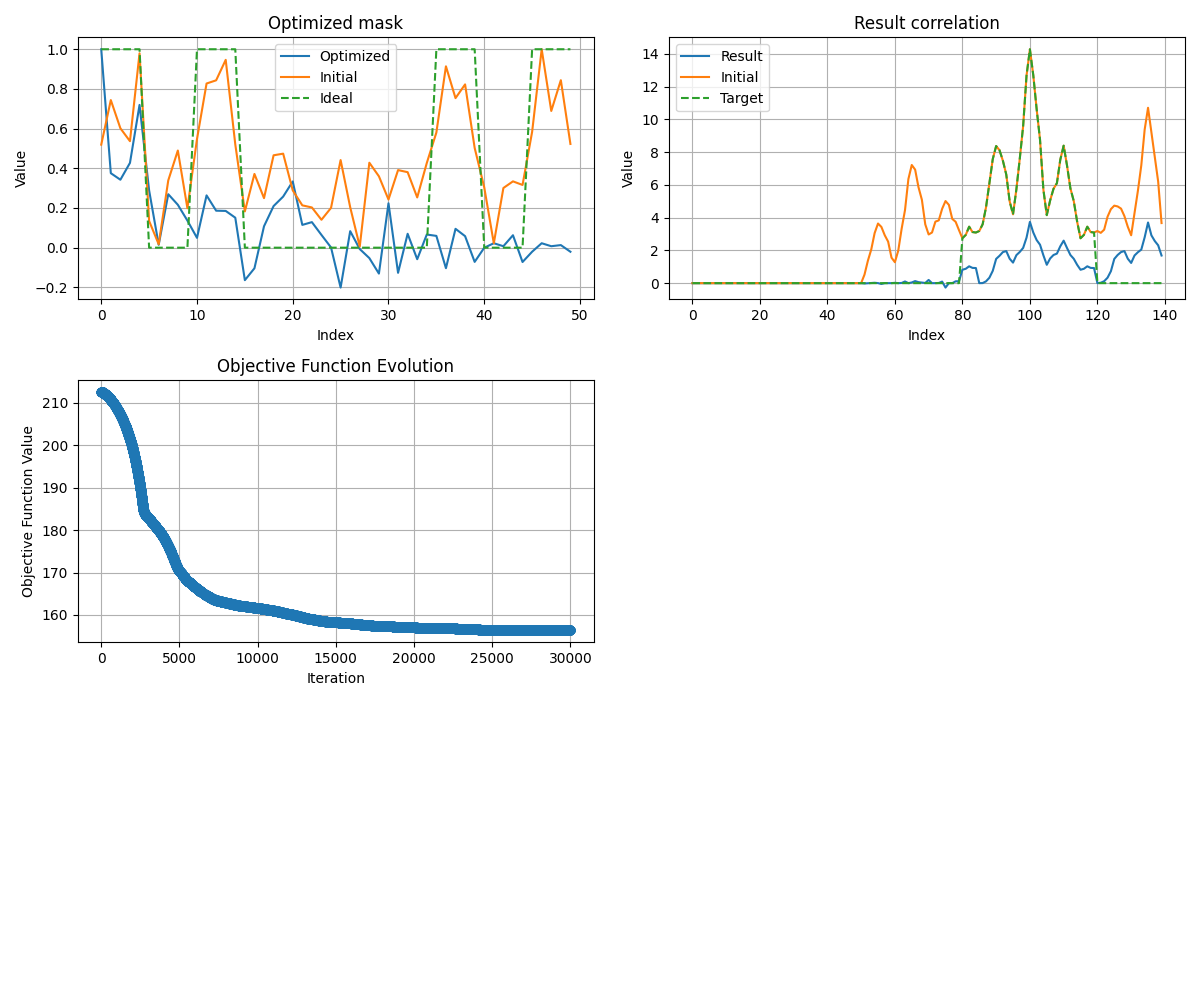

Optimization Result:
       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 156.39070325710463
             x: [ 1.000e+00  3.754e-01 ...  1.306e-02 -2.048e-02]
           nit: 30000
          nfev: 34505
 final_simplex: (array([[ 1.000e+00,  3.754e-01, ...,  1.306e-02,
                        -2.048e-02],
                       [ 3.351e+00,  1.258e+00, ...,  4.403e-02,
                        -6.862e-02],
                       ...,
                       [ 3.351e+00,  1.258e+00, ...,  4.361e-02,
                        -6.852e-02],
                       [ 3.351e+00,  1.258e+00, ...,  4.391e-02,
                        -6.861e-02]]), array([ 1.564e+02,  1.564e+02, ...,  1.564e+02,  1.564e+02]))


In [12]:
preamble_enum = Preambule.Ideal
preamble = preambule_list[preamble_enum.value]

expected_maximum = preamble.get_expected_maximum() + signal_start_pause_length
full_signal_max = expected_maximum + 40

target = np.array(digitized_signal)[:full_signal_max]

initial_guess = np.random.uniform(0, 1, len(preamble.get_coefficients())) + preamble.get_coefficients()
initial_guess = normalize_signal(initial_guess)

target_impulse = [8, 10, 13, 15, 13, 10, 8]
target_impulse_side_length = int((len(target_impulse) - 1) / 2)
target_corr_left_size = expected_maximum - target_impulse_side_length
target_corr_right_size = full_signal_max - target_corr_left_size - len(target_impulse)
target_corr = np.concatenate((np.zeros(target_corr_left_size), target_impulse, np.zeros(target_corr_right_size)))

initial_corr = correlate_signals(target, initial_guess)

target_corr = initial_corr.copy()
target_corr[:80] = 0
target_corr[120:] = 0

optimizer_minimize = CorrelationOptimisationMinimize(target_corr, target)
optimizer_minimize.optimize(initial_guess, 30000)
result = optimizer_minimize.get_result()

result_mask = normalize_signal(result.x)
print("Result x:")
[print(f"{x:.2f}", end =" ") for x in result_mask]

# Extract data for plotting
history = np.array(optimizer_minimize.get_history())
z_vals = np.array([optimizer_minimize.objective_function(x) for x in history])

result_corr = correlate_signals(target, result_mask)

# Plot evolution of the objective function
plt.figure(figsize=(12, 10))
plt.subplot(321)
plt.plot(result_mask, label="Optimized")
plt.plot(initial_guess, label="Initial")
plt.plot(preamble.get_coefficients(), '--', label = "Ideal")
plt.title("Optimized mask")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.subplot(322)
plt.title("Result correlation")
plt.xlabel("Index")
plt.ylabel("Value")
plt.plot(result_corr, label = "Result")
plt.plot(initial_corr, label = "Initial")
plt.plot(target_corr, '--', label = "Target")
plt.legend()
plt.grid()
plt.subplot(323)
plt.plot(z_vals, marker='o')
plt.title("Objective Function Evolution")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.grid()
plt.tight_layout()
plt.show()

# Print optimization results
print("Optimization Result:")
print(result)

# TODO: siekti kad koreliacijos rezultatas atitinku vienetini impulsa
# TODO: atimti korelaicijos rezultata is vienetinio impulso ir isimti moduli kad siektu 0
# TODO: arba visa arba maziau duoti atskaitu